In [2]:
import glob
from PIL import Image
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from collections import OrderedDict

In [3]:
token = "Flickr8k/Flickr8k_text/Flickr8k.token.txt"

In [4]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of images

In [5]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [6]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
images = 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'

In [8]:
img = glob.glob(images+'*.jpg')

In [9]:
img[:5]

['Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [10]:
train_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'

In [11]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [12]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [13]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [14]:
val_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [15]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [16]:
test_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

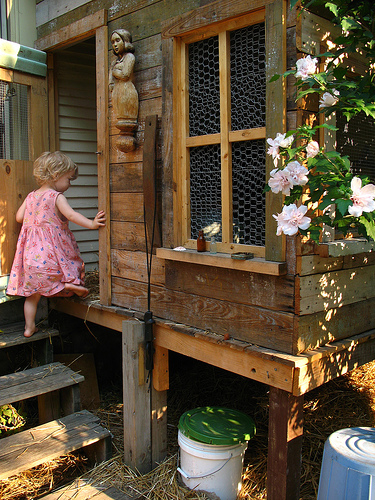

In [18]:
Image.open(train_img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [19]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [20]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

W0628 17:57:49.824591  4312 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


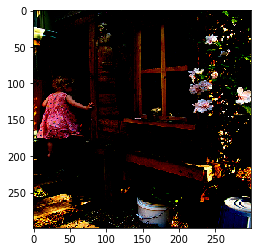

In [21]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [22]:
model = InceptionV3(weights='imagenet')

W0628 17:57:52.998110  4312 deprecation_wrapper.py:119] From C:\Users\Karan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 17:57:53.020081  4312 deprecation_wrapper.py:119] From C:\Users\Karan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 17:57:53.026067  4312 deprecation_wrapper.py:119] From C:\Users\Karan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 17:57:53.066006  4312 deprecation_wrapper.py:119] From C:\Users\Karan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0628 17:57:53.068999  4312 deprecation_wrapper.py:119] 

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 9a0d58056eeedaa3f26cb7ebd46da564 so we will re-download the data.


44761088/96112376 [============>.................] - ETA: 6: - ETA: 9: - ETA: 14:0 - ETA: 9:2 - ETA: 7: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA:

96116736/96112376 [==============================] - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [23]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [24]:
tryi = model_new.predict(preprocess(train_img[0]))

In [25]:
tryi.shape

(1, 2048)

In [26]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [27]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [46:19<00:00,  2.62it/s]  


In [28]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [29]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [30]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [31]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [07:01<00:00,  1.97it/s]


In [32]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [33]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [34]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [35]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [36]:
len(train_d)

6000

In [37]:
##train_d[images+'3556792157_d09d42bef7.jpg']

In [38]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [39]:
len(val_d)

1000

In [40]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [41]:
len(test_d)

1000

## Calculating unique words in library

In [42]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [43]:
words = [i.split() for i in caps]

In [44]:
unique = []
for i in words:
    unique.extend(i)

In [45]:
unique = list(set(unique))

In [46]:
 with open("unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d)

In [47]:
unique = pickle.load(open('unique.p', 'rb'))

In [48]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [49]:
word2idx = {val:index for index, val in enumerate(unique)}

In [50]:
word2idx['<start>']

7429

In [51]:
idx2word = {index:val for index, val in enumerate(unique)}

In [52]:
idx2word[5553]

'haystack'

Calculating the maximum length among all the captions

In [53]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [54]:
len(unique), max_len

(8256, 40)

In [55]:
vocab_size = len(unique)

In [56]:
vocab_size

8256

Adding

In [57]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [58]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [59]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [60]:
len(df)

30000

In [61]:
c = [i for i in df['captions']]
len(c)

30000

In [62]:
imgs = [i for i in df['image_id']]

In [63]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [64]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 7429
Woman => 678
writing => 7118
on => 4550
a => 3429
pad => 7070
in => 6216
room => 2296
with => 5052
gold => 1960
, => 6229
decorated => 3446
walls => 4244
. => 4832
<end> => 7838


In [65]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [66]:
samples_per_epoch

383454

## Generator

We will use the encoding of an image and use a start word to predict the next word. After that, we will again use the same image and use the predicted word to predict the next word. So, the image will be used at every iteration for the entire caption. This is how we will generate the caption for an image. Hence, we need to create a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully. Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [67]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Lets Create the model

In [68]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [69]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [70]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Merging the models and creating a softmax classifier

In [74]:
# final_model = Sequential([
#         Merge([image_model, caption_model], mode='concat', concat_axis=1),
#         ##concatenate([image_model,caption_model]),
#         Bidirectional(LSTM(256, return_sequences=False)),
#         Dense(vocab_size),
#         Activation('softmax')
#     ])
from keras.layers import concatenate
concat_layers = concatenate([image_model.output, caption_model.output])
layer = Bidirectional(LSTM(256, return_sequences=False))(concat_layers)
layer = Dense(vocab_size)(layer)
outlayer = Activation('softmax')(layer)
final_model = Model([image_model.input, caption_model.input], [outlayer])

In [ ]:
# ##from keras import concatenate
# from keras.layers.merge import concatenate
# final_model = Sequential()
# final_model.add(merge([image_model,caption_model],mode='concat',concat_axis=-1))
# ##final_model = concatenate([image_model,caption_model])
# final_model.add(Bidirectional(LSTM(256, return_sequences=False)))
# final_model.add(Dense(vocab_size))

In [122]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [123]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      dense_1_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

In [1]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

NameError: name 'final_model' is not defined

In [124]:
final_model.fit_generator(data_generator(batch_size=1), epochs=1, verbose=2, steps_per_epoch=100)

Epoch 1/1
 - 37s - loss: 8.5600 - acc: 0.1700


In [110]:
final_model.fit_generator(data_generator(batch_size=1), epochs=10, verbose=2, steps_per_epoch=1000)

Epoch 1/10
 - 280s - loss: 7.9090 - acc: 0.1910
Epoch 2/10
 - 277s - loss: 7.8409 - acc: 0.2020
Epoch 3/10
 - 279s - loss: 7.6491 - acc: 0.1980
Epoch 4/10
 - 293s - loss: 8.0099 - acc: 0.1890
Epoch 5/10
 - 291s - loss: 8.0302 - acc: 0.1760
Epoch 6/10
 - 284s - loss: 8.2121 - acc: 0.1650
Epoch 7/10
 - 295s - loss: 8.2127 - acc: 0.1720
Epoch 8/10
 - 337s - loss: 8.1314 - acc: 0.1840
Epoch 9/10
 - 303s - loss: 8.1976 - acc: 0.1860
Epoch 10/10
 - 302s - loss: 8.2870 - acc: 0.1840


In [125]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')


In [126]:
final_model.fit_generator(data_generator(batch_size=1), epochs=1, verbose=2, steps_per_epoch=100)

Epoch 1/1
 - 32s - loss: 8.6008 - acc: 0.2100


In [118]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [119]:
final_model.fit_generator(data_generator(batch_size=1), epochs=1, verbose=2, steps_per_epoch=100)

Epoch 1/1
 - 32s - loss: 8.2703 - acc: 0.1800


In [120]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [121]:
final_model.fit_generator(data_generator(batch_size=1), epochs=1, verbose=2, steps_per_epoch=100)

Epoch 1/1
 - 31s - loss: 7.0630 - acc: 0.1600


In [96]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [97]:
final_model.fit_generator(data_generator(batch_size=1), epochs=1, verbose=2, steps_per_epoch=1000)

Epoch 1/1
 - 31s - loss: 6.6586 - acc: 0.1900


In [131]:
final_model.fit_generator(data_generator(batch_size=1), epochs=1, verbose=2, steps_per_epoch=1)

Epoch 1/1
 - 3s - loss: 0.2776 - acc: 1.0000


## Predict funtion

In [100]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [101]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

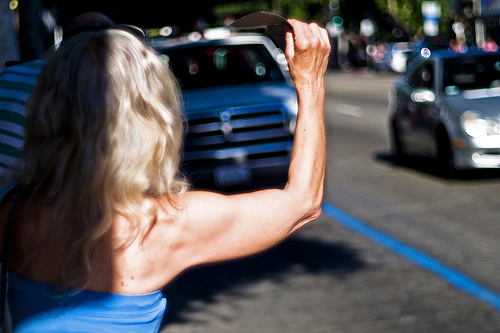

In [127]:
try_image = test_img[0]
Image.open(try_image)

In [128]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
Beam Search, k=3: .
Beam Search, k=5: .
Beam Search, k=7: .


In [2]:
try_image2 = test_img[7]
Image.open(try_image2)

NameError: name 'test_img' is not defined

In [133]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
Beam Search, k=3: .
Beam Search, k=5: .
Beam Search, k=7: .
